In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
from statsmodels.graphics.tsaplots import month_plot, quarter_plot,\
                                           plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error, \
                            root_mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import ParameterGrid

from darts.timeseries import TimeSeries
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel

/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('electricity.csv', index_col='ds', parse_dates=True)
df = df.query('unique_id == "DE"')
df = df.asfreq('h')
df

,unique_id,y,Exogenous1,Exogenous2
ds,,,,
2017-10-22 00:00:00,DE,19.10,587.25,16972.75
2017-10-22 01:00:00,DE,19.03,623.00,16254.50
2017-10-22 02:00:00,DE,16.90,650.00,15940.25
2017-10-22 03:00:00,DE,12.98,687.25,15959.50
2017-10-22 04:00:00,DE,9.24,717.25,16071.50
...,...,...,...,...
2017-12-30 19:00:00,DE,16.18,1519.50,19326.00
2017-12-30 20:00:00,DE,11.13,1526.75,18135.25
2017-12-30 21:00:00,DE,4.62,1514.75,17631.50


Exploratory Data Analysis

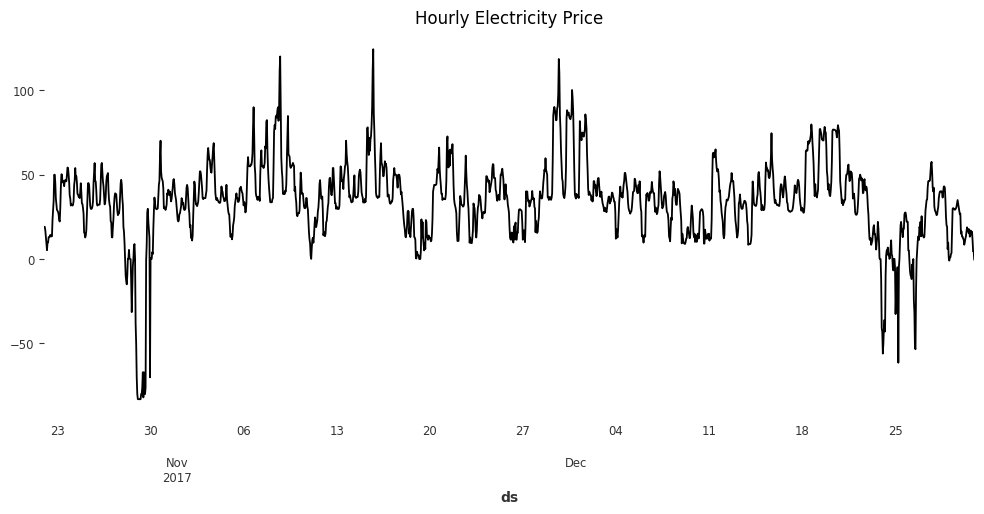

In [3]:
fig = plt.figure(figsize=(12, 5))
df['y'].plot(title='Hourly Electricity Price')
plt.grid('')
plt.show()

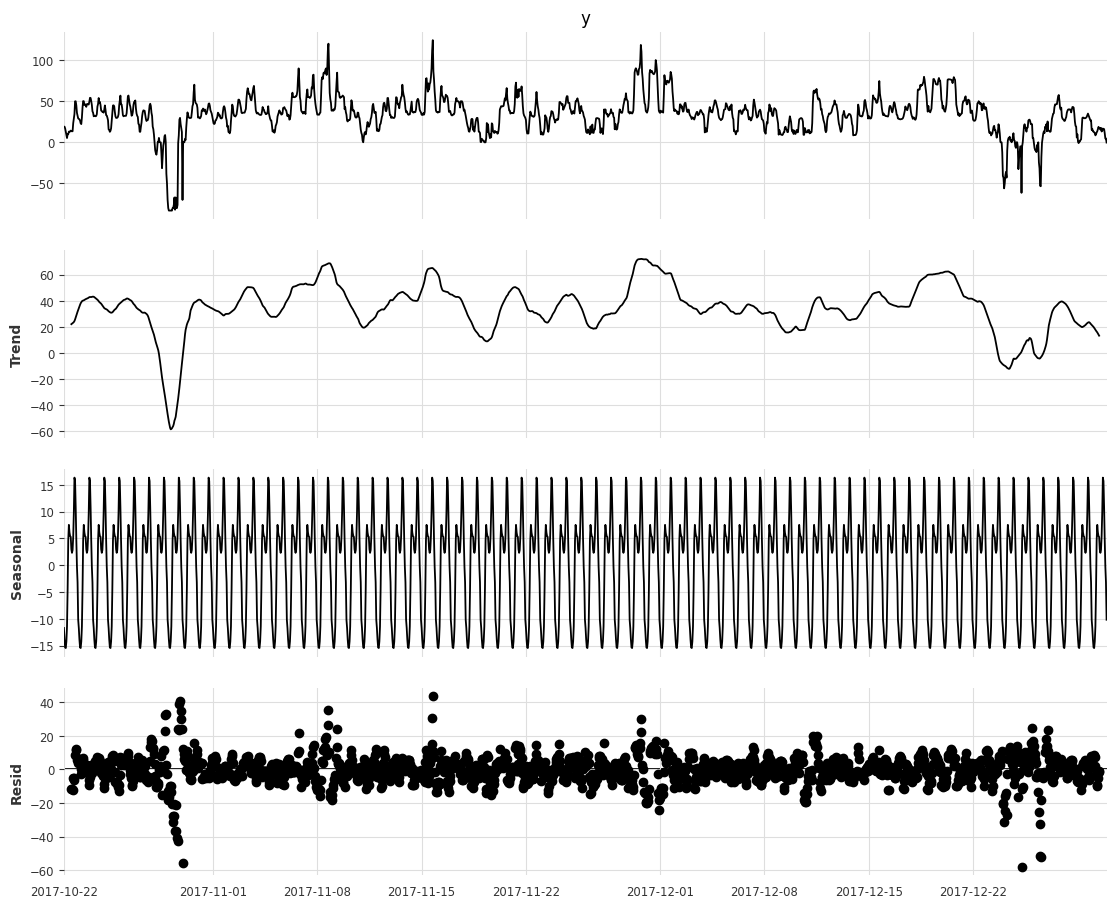

In [5]:
decomposition = seasonal_decompose(df['y'], model='add', period=24)


fig = decomposition.plot()
fig.set_size_inches(12, 10)
plt.show()

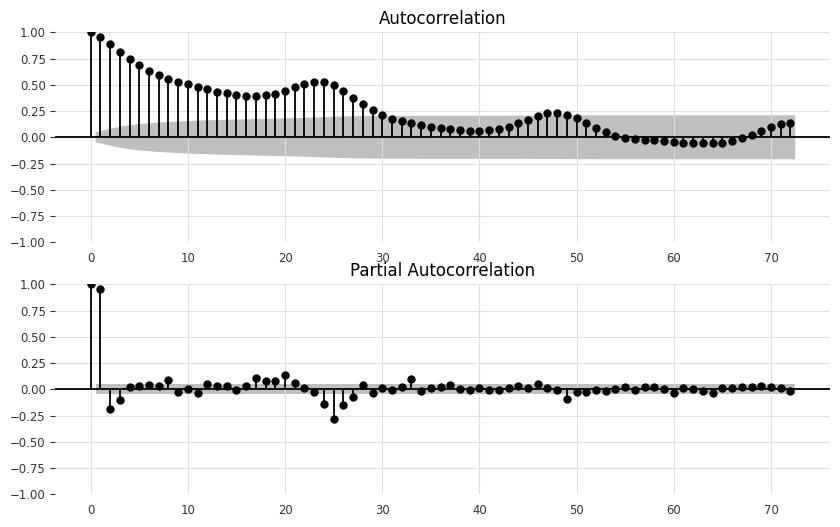

In [4]:
fig, ax = plt.subplots(2, 1, figsize=(10, 6))
plot_acf(df['y'], lags=72, ax=ax[0])
plot_pacf(df['y'], lags=72, ax=ax[1])
plt.show()

In [5]:
series = TimeSeries.from_dataframe(df, value_cols='y')
series

<TimeSeries (DataArray) (ds: 1680, component: 1, sample: 1)> Size: 13kB
array([[[19.1 ]],

       [[19.03]],

       [[16.9 ]],

       ...,

       [[ 4.62]],

       [[ 4.71]],

       [[-0.27]]])
Coordinates:
  * ds         (ds) datetime64[ns] 13kB 2017-10-22 ... 2017-12-30T23:00:00
  * component  (component) object 8B 'y'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [6]:
def encode_year(idx):
    return(idx.year - 2000) / 50

add_encoders = {
    'cyclic': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']},
    'datetime_attribute': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']},
    'position': {'past': ['relative'], 'future': ['relative']},
    'custom': {'past': [encode_year], 'future': [encode_year]},
    'transformer': Scaler(),
    'tz': 'CET'}

Past Covariates

In [7]:
X_past = df.iloc[:, 2:]
past_covariates = TimeSeries.from_dataframe(X_past)

past_covariates

<TimeSeries (DataArray) (ds: 1680, component: 2, sample: 1)> Size: 27kB
array([[[  587.25],
        [16972.75]],

       [[  623.  ],
        [16254.5 ]],

       [[  650.  ],
        [15940.25]],

       ...,

       [[ 1514.75],
        [17631.5 ]],

       [[ 1484.75],
        [17553.75]],

       [[ 1440.75],
        [16754.5 ]]])
Coordinates:
  * ds         (ds) datetime64[ns] 13kB 2017-10-22 ... 2017-12-30T23:00:00
  * component  (component) object 16B 'Exogenous1' 'Exogenous2'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

Future Covariates

In [8]:
future_df = pd.read_csv('electricity-future.csv', 
                        index_col='ds', 
                        parse_dates=True)

future_df = future_df.query('unique_id == "DE"')
X_future = future_df.iloc[:, 1:]

X = pd.concat([X_past, X_future])

future_covariates = TimeSeries.from_dataframe(X)

In [9]:
scaler_y = Scaler()
scaler_covariates = Scaler()

y_transformed = scaler_y.fit_transform(series)

past_covariates_transformed = scaler_covariates.fit_transform(past_covariates)
future_covariates_transformed = scaler_covariates.fit_transform(future_covariates)

TFT Model

In [10]:
model = TFTModel(
    input_chunk_length = 96,
    output_chunk_length = 24,
    hidden_size = 16,
    lstm_layers = 2,
    num_attention_heads = 4,
    dropout = 0.1,
    batch_size = 64,
    n_epochs = 10,
    add_encoders = add_encoders,
    use_static_covariates = True,
    pl_trainer_kwargs = {'accelerator': 'cpu'}
)

model.fit(
    y_transformed,
    past_covariates = past_covariates_transformed,
    future_covariates = future_covariates_transformed
)

/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      |

Epoch 9: 100%|██████████| 25/25 [00:04<00:00,  5.46it/s, train_loss=0.236]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 25/25 [00:04<00:00,  5.46it/s, train_loss=0.236]


TFTModel(output_chunk_shift=0, hidden_size=16, lstm_layers=2, num_attention_heads=4, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.1, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=False, loss_fn=None, likelihood=None, norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=96, output_chunk_length=24, batch_size=64, n_epochs=10, add_encoders={'cyclic': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'datetime_attribute': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'position': {'past': ['relative'], 'future': ['relative']}, 'custom': {'past': [<function encode_year at 0x7f1146e3ab60>], 'future': [<function encode_year at 0x7f1146e3ab60>]}, 'transformer': Scaler, 'tz': 'CET'}, pl_trainer_kwargs={'accelerator': 'cpu'})

Cross-Validation

In [11]:
cv = model.historical_forecasts(
    series = y_transformed,
    past_covariates = past_covariates_transformed,
    future_covariates = future_covariates_transformed,
    forecast_horizon = 24,
    start = df.shape[0] - 240,
    retrain = True,
    stride = 24,
    last_points_only = False)

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metri

Epoch 9: 100%|██████████| 21/21 [00:03<00:00,  5.43it/s, train_loss=0.291]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 21/21 [00:03<00:00,  5.43it/s, train_loss=0.291]


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection       

Epoch 9: 100%|██████████| 22/22 [00:04<00:00,  5.36it/s, train_loss=0.264]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 22/22 [00:04<00:00,  5.36it/s, train_loss=0.264]

/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0

Epoch 9: 100%|██████████| 22/22 [00:04<00:00,  5.35it/s, train_loss=0.332]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 22/22 [00:04<00:00,  5.35it/s, train_loss=0.332]


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection       

Epoch 9: 100%|██████████| 22/22 [00:04<00:00,  5.17it/s, train_loss=0.373]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 22/22 [00:04<00:00,  5.17it/s, train_loss=0.373]


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection       

Epoch 9: 100%|██████████| 23/23 [00:04<00:00,  4.84it/s, train_loss=0.361]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 23/23 [00:04<00:00,  4.84it/s, train_loss=0.361]

/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0

Epoch 9: 100%|██████████| 23/23 [00:04<00:00,  5.35it/s, train_loss=0.291]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 23/23 [00:04<00:00,  5.34it/s, train_loss=0.291]


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection       

Epoch 9: 100%|██████████| 23/23 [00:04<00:00,  5.24it/s, train_loss=0.267]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 23/23 [00:04<00:00,  5.24it/s, train_loss=0.267]


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection       

Epoch 9: 100%|██████████| 24/24 [00:04<00:00,  5.26it/s, train_loss=0.278]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 24/24 [00:04<00:00,  5.26it/s, train_loss=0.278]


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection       

Epoch 9: 100%|██████████| 24/24 [00:04<00:00,  5.31it/s, train_loss=0.302]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 24/24 [00:04<00:00,  5.31it/s, train_loss=0.302]


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection       

Epoch 9: 100%|██████████| 25/25 [00:04<00:00,  5.36it/s, train_loss=0.557]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 25/25 [00:04<00:00,  5.35it/s, train_loss=0.557]

/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [12]:
rmse_cv = []

for i in range(len(cv)):

    predictions = TimeSeries.pd_series(scaler_y.inverse_transform(cv[i]))

    start = predictions.index.min()
    end = predictions.index.max()
    actuals = df['y'][start:end]

    error_cv = root_mean_squared_error(actuals, predictions)
    rmse_cv.append(error_cv)

np.average(rmse_cv)

31.28983581132337

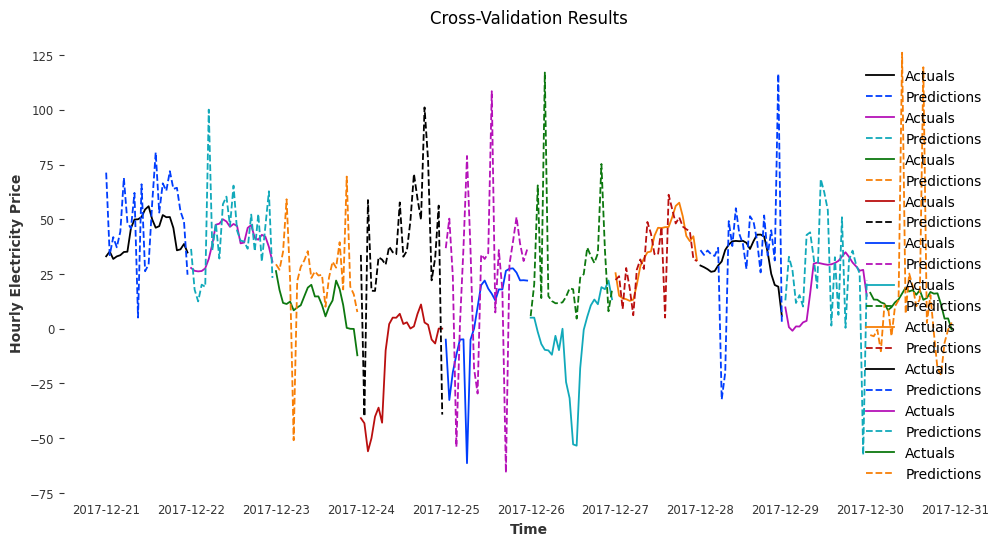

In [13]:
fig, ax = plt.subplots(figsize=(12, 6))

for i in range(len(cv)):

    predictions = TimeSeries.pd_series(scaler_y.inverse_transform(cv[i]))

    start = predictions.index.min()
    end = predictions.index.max()
    actuals = df['y'][start:end]

    ax.plot(actuals, label='Actuals')
    ax.plot(predictions, label='Predictions', linestyle='dashed')

ax.set_xlabel('Time')
ax.set_ylabel('Hourly Electricity Price')
ax.set_title('Cross-Validation Results')

ax.legend()
plt.grid('')
plt.show()


Parameter Tuning

In [14]:
from sklearn.model_selection import ParameterSampler

In [15]:
# Parameter Grid

param_grid = {
    'input_chunk_length': [48, 96, 172],
    'output_chunk_length': [24],
    'hidden_size': [8, 16, 24],
    'num_attention_heads': [4, 6],
    'dropout': [0.1, 0.2],
    'batch_size': [32, 64, 128],
    'lstm_layers': [2, 4],
    'n_epochs': [10, 20]}

In [16]:
n_iter = 12

param_list = list(ParameterSampler(param_grid, n_iter=n_iter, random_state=42))

param_list2 = param_list

param_list

[{'output_chunk_length': 24,
  'num_attention_heads': 4,
  'n_epochs': 10,
  'lstm_layers': 2,
  'input_chunk_length': 172,
  'hidden_size': 24,
  'dropout': 0.2,
  'batch_size': 128},
 {'output_chunk_length': 24,
  'num_attention_heads': 6,
  'n_epochs': 20,
  'lstm_layers': 2,
  'input_chunk_length': 48,
  'hidden_size': 8,
  'dropout': 0.2,
  'batch_size': 32},
 {'output_chunk_length': 24,
  'num_attention_heads': 4,
  'n_epochs': 10,
  'lstm_layers': 4,
  'input_chunk_length': 96,
  'hidden_size': 16,
  'dropout': 0.1,
  'batch_size': 64},
 {'output_chunk_length': 24,
  'num_attention_heads': 4,
  'n_epochs': 20,
  'lstm_layers': 4,
  'input_chunk_length': 48,
  'hidden_size': 16,
  'dropout': 0.1,
  'batch_size': 32},
 {'output_chunk_length': 24,
  'num_attention_heads': 4,
  'n_epochs': 10,
  'lstm_layers': 2,
  'input_chunk_length': 96,
  'hidden_size': 16,
  'dropout': 0.2,
  'batch_size': 128},
 {'output_chunk_length': 24,
  'num_attention_heads': 6,
  'n_epochs': 20,
  'lstm_

In [17]:
fixed_params = {
    'use_static_covariates': True,
    'add_encoders': add_encoders,
    'pl_trainer_kwargs': {'accelerator': 'cpu'}
}

for params in param_list:
    params.update(fixed_params)

param_list

[{'output_chunk_length': 24,
  'num_attention_heads': 4,
  'n_epochs': 10,
  'lstm_layers': 2,
  'input_chunk_length': 172,
  'hidden_size': 24,
  'dropout': 0.2,
  'batch_size': 128,
  'use_static_covariates': True,
  'add_encoders': {'cyclic': {'future': ['hour',
     'day',
     'dayofweek',
     'week',
     'month']},
   'datetime_attribute': {'future': ['hour',
     'day',
     'dayofweek',
     'week',
     'month']},
   'position': {'past': ['relative'], 'future': ['relative']},
   'custom': {'past': [<function __main__.encode_year(idx)>],
    'future': [<function __main__.encode_year(idx)>]},
   'transformer': Scaler,
   'tz': 'CET'},
  'pl_trainer_kwargs': {'accelerator': 'cpu'}},
 {'output_chunk_length': 24,
  'num_attention_heads': 6,
  'n_epochs': 20,
  'lstm_layers': 2,
  'input_chunk_length': 48,
  'hidden_size': 8,
  'dropout': 0.2,
  'batch_size': 32,
  'use_static_covariates': True,
  'add_encoders': {'cyclic': {'future': ['hour',
     'day',
     'dayofweek',
     'w

In [18]:
rmse = []

k = 1
for params in param_list[:6]:

    model = TFTModel(**params)

    print(f'\n\n\n\n\n\n\n\n\nround {k} of tuning \n\n\n\n\n\n\n\n\n')
    cv = model.historical_forecasts(
        series = y_transformed,
        past_covariates = past_covariates_transformed,
        future_covariates = future_covariates_transformed,
        forecast_horizon = 24,
        start = df.shape[0] - 240,
        retrain = True,
        stride = 24,
        last_points_only = False)
    
    rmse_cv = []

    for i in range(len(cv)):

        predictions = TimeSeries.pd_series(scaler_y.inverse_transform(cv[i]))

        start = predictions.index.min()
        end = predictions.index.max()
        actuals = df['y'][start:end]

        error_cv = root_mean_squared_error(actuals, predictions)
        rmse_cv.append(error_cv)

    rmse.append(np.average(rmse_cv))

    k += 1

/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      |










round 1 of tuning 









Epoch 9: 100%|██████████| 10/10 [00:05<00:00,  1.87it/s, train_loss=0.437]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 10/10 [00:05<00:00,  1.87it/s, train_loss=0.437]

/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0

Epoch 9: 100%|██████████| 10/10 [00:05<00:00,  1.80it/s, train_loss=0.412]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 10/10 [00:05<00:00,  1.80it/s, train_loss=0.412]

/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0

Epoch 9: 100%|██████████| 11/11 [00:05<00:00,  1.90it/s, train_loss=0.400]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 11/11 [00:05<00:00,  1.90it/s, train_loss=0.400]


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection       

Epoch 9: 100%|██████████| 11/11 [00:05<00:00,  1.89it/s, train_loss=0.456]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 11/11 [00:05<00:00,  1.89it/s, train_loss=0.456]

/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0

Epoch 9: 100%|██████████| 11/11 [00:05<00:00,  1.85it/s, train_loss=0.419]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 11/11 [00:05<00:00,  1.85it/s, train_loss=0.419]

/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0

Epoch 9: 100%|██████████| 11/11 [00:06<00:00,  1.78it/s, train_loss=0.455]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 11/11 [00:06<00:00,  1.78it/s, train_loss=0.455]

/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0

Epoch 9: 100%|██████████| 11/11 [00:06<00:00,  1.82it/s, train_loss=0.347]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 11/11 [00:06<00:00,  1.82it/s, train_loss=0.347]

/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0

Epoch 9: 100%|██████████| 12/12 [00:06<00:00,  1.94it/s, train_loss=0.295]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 12/12 [00:06<00:00,  1.94it/s, train_loss=0.295]


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection       

Epoch 9: 100%|██████████| 12/12 [00:06<00:00,  1.88it/s, train_loss=0.462]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 12/12 [00:06<00:00,  1.88it/s, train_loss=0.462]

/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0

Epoch 9: 100%|██████████| 12/12 [00:06<00:00,  1.87it/s, train_loss=0.331]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 12/12 [00:06<00:00,  1.87it/s, train_loss=0.331]

/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.












round 2 of tuning 











/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      |

Epoch 19: 100%|██████████| 43/43 [00:04<00:00, 10.74it/s, train_loss=0.291]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 43/43 [00:04<00:00, 10.73it/s, train_loss=0.291]


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection       

Epoch 19: 100%|██████████| 44/44 [00:03<00:00, 11.45it/s, train_loss=0.177]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 44/44 [00:03<00:00, 11.44it/s, train_loss=0.177]


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection       

Epoch 19: 100%|██████████| 45/45 [00:03<00:00, 11.67it/s, train_loss=0.190]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 45/45 [00:03<00:00, 11.67it/s, train_loss=0.190]


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection       

Epoch 19: 100%|██████████| 46/46 [00:03<00:00, 11.52it/s, train_loss=0.180]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 46/46 [00:03<00:00, 11.52it/s, train_loss=0.180]


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection       

Epoch 19: 100%|██████████| 46/46 [00:04<00:00, 11.47it/s, train_loss=0.148]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 46/46 [00:04<00:00, 11.47it/s, train_loss=0.148]


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection       

Epoch 19: 100%|██████████| 47/47 [00:04<00:00, 11.49it/s, train_loss=0.175]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 47/47 [00:04<00:00, 11.49it/s, train_loss=0.175]


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection       

Epoch 19: 100%|██████████| 48/48 [00:04<00:00, 11.18it/s, train_loss=0.249]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 48/48 [00:04<00:00, 11.18it/s, train_loss=0.249]


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection       

Epoch 19: 100%|██████████| 49/49 [00:04<00:00, 11.04it/s, train_loss=0.142]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 49/49 [00:04<00:00, 11.04it/s, train_loss=0.142]


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection       

Epoch 19: 100%|██████████| 49/49 [00:04<00:00, 10.51it/s, train_loss=0.140]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 49/49 [00:04<00:00, 10.51it/s, train_loss=0.140]


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection       

Epoch 19: 100%|██████████| 50/50 [00:04<00:00, 10.91it/s, train_loss=0.165]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 50/50 [00:04<00:00, 10.91it/s, train_loss=0.165]


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.











round 3 of tuning 











/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      |

Epoch 9: 100%|██████████| 21/21 [00:04<00:00,  4.31it/s, train_loss=0.374]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 21/21 [00:04<00:00,  4.31it/s, train_loss=0.374]

/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0

Epoch 9: 100%|██████████| 22/22 [00:04<00:00,  4.43it/s, train_loss=0.289]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 22/22 [00:04<00:00,  4.43it/s, train_loss=0.289]


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection       

Epoch 9: 100%|██████████| 22/22 [00:04<00:00,  4.42it/s, train_loss=0.540]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 22/22 [00:04<00:00,  4.42it/s, train_loss=0.540]


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection       

Epoch 9: 100%|██████████| 22/22 [00:05<00:00,  4.24it/s, train_loss=0.379]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 22/22 [00:05<00:00,  4.24it/s, train_loss=0.379]

/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0

Epoch 9: 100%|██████████| 23/23 [00:05<00:00,  4.40it/s, train_loss=0.265]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 23/23 [00:05<00:00,  4.40it/s, train_loss=0.265]


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection       

Epoch 9: 100%|██████████| 23/23 [00:05<00:00,  4.29it/s, train_loss=0.318]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 23/23 [00:05<00:00,  4.29it/s, train_loss=0.318]


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection       

Epoch 9: 100%|██████████| 23/23 [00:05<00:00,  4.16it/s, train_loss=0.290]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 23/23 [00:05<00:00,  4.16it/s, train_loss=0.290]

/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0

Epoch 9: 100%|██████████| 24/24 [00:05<00:00,  4.32it/s, train_loss=0.469]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 24/24 [00:05<00:00,  4.32it/s, train_loss=0.469]


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection       

Epoch 9: 100%|██████████| 24/24 [00:05<00:00,  4.35it/s, train_loss=0.377]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 24/24 [00:05<00:00,  4.35it/s, train_loss=0.377]

/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0

Epoch 9: 100%|██████████| 25/25 [00:05<00:00,  4.35it/s, train_loss=0.228]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 25/25 [00:05<00:00,  4.35it/s, train_loss=0.228]


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.











round 4 of tuning 











/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      |

Epoch 19: 100%|██████████| 43/43 [00:06<00:00,  7.05it/s, train_loss=0.132]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 43/43 [00:06<00:00,  7.05it/s, train_loss=0.132]


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection       

Epoch 19: 100%|██████████| 44/44 [00:06<00:00,  7.12it/s, train_loss=0.168]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 44/44 [00:06<00:00,  7.12it/s, train_loss=0.168]


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection       

Epoch 19: 100%|██████████| 45/45 [00:06<00:00,  7.28it/s, train_loss=0.134]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 45/45 [00:06<00:00,  7.28it/s, train_loss=0.134]

/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train


Epoch 19: 100%|██████████| 46/46 [00:06<00:00,  7.11it/s, train_loss=0.124]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 46/46 [00:06<00:00,  7.11it/s, train_loss=0.124]

/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0

Epoch 19: 100%|██████████| 46/46 [00:06<00:00,  7.14it/s, train_loss=0.143]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 46/46 [00:06<00:00,  7.14it/s, train_loss=0.143]


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection       

Epoch 19: 100%|██████████| 47/47 [00:06<00:00,  7.15it/s, train_loss=0.147]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 47/47 [00:06<00:00,  7.15it/s, train_loss=0.147]


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection       

Epoch 19: 100%|██████████| 48/48 [00:06<00:00,  7.21it/s, train_loss=0.153]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 48/48 [00:06<00:00,  7.21it/s, train_loss=0.153]


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection       

Epoch 19: 100%|██████████| 49/49 [00:06<00:00,  7.27it/s, train_loss=0.124]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 49/49 [00:06<00:00,  7.26it/s, train_loss=0.124]

/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0

Epoch 19: 100%|██████████| 49/49 [00:06<00:00,  7.18it/s, train_loss=0.116]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 49/49 [00:06<00:00,  7.18it/s, train_loss=0.116]


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection       

Epoch 19: 100%|██████████| 50/50 [00:06<00:00,  7.18it/s, train_loss=0.132]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 50/50 [00:06<00:00,  7.18it/s, train_loss=0.132]


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.











round 5 of tuning 











/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      |

Epoch 9: 100%|██████████| 11/11 [00:03<00:00,  3.40it/s, train_loss=0.518]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 11/11 [00:03<00:00,  3.40it/s, train_loss=0.518]


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection       

Epoch 9: 100%|██████████| 11/11 [00:03<00:00,  3.37it/s, train_loss=0.457]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 11/11 [00:03<00:00,  3.37it/s, train_loss=0.457]


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection       

Epoch 9: 100%|██████████| 11/11 [00:03<00:00,  3.25it/s, train_loss=0.400]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 11/11 [00:03<00:00,  3.25it/s, train_loss=0.400]

/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0

Epoch 9: 100%|██████████| 11/11 [00:03<00:00,  3.17it/s, train_loss=0.430]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 11/11 [00:03<00:00,  3.17it/s, train_loss=0.430]

/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0

Epoch 9: 100%|██████████| 12/12 [00:03<00:00,  3.37it/s, train_loss=0.639]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 12/12 [00:03<00:00,  3.37it/s, train_loss=0.639]


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection       

Epoch 9: 100%|██████████| 12/12 [00:03<00:00,  3.36it/s, train_loss=0.543]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 12/12 [00:03<00:00,  3.36it/s, train_loss=0.543]


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection       

Epoch 9: 100%|██████████| 12/12 [00:03<00:00,  3.32it/s, train_loss=0.453]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 12/12 [00:03<00:00,  3.32it/s, train_loss=0.453]


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection       

Epoch 9: 100%|██████████| 12/12 [00:03<00:00,  3.30it/s, train_loss=0.527]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 12/12 [00:03<00:00,  3.30it/s, train_loss=0.527]

/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0

Epoch 9: 100%|██████████| 12/12 [00:03<00:00,  3.32it/s, train_loss=0.438]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 12/12 [00:03<00:00,  3.32it/s, train_loss=0.438]

/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0

Epoch 9: 100%|██████████| 13/13 [00:03<00:00,  3.44it/s, train_loss=0.269]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 13/13 [00:03<00:00,  3.44it/s, train_loss=0.269]

/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.











round 6 of tuning 











/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      |

Epoch 19: 100%|██████████| 21/21 [00:04<00:00,  4.88it/s, train_loss=0.156]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 21/21 [00:04<00:00,  4.88it/s, train_loss=0.156]


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection       

Epoch 19: 100%|██████████| 22/22 [00:04<00:00,  4.80it/s, train_loss=0.109]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 22/22 [00:04<00:00,  4.80it/s, train_loss=0.109]

/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0

Epoch 19: 100%|██████████| 22/22 [00:04<00:00,  4.71it/s, train_loss=0.173]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 22/22 [00:04<00:00,  4.71it/s, train_loss=0.173]


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection       

Epoch 19: 100%|██████████| 22/22 [00:04<00:00,  4.74it/s, train_loss=0.179]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 22/22 [00:04<00:00,  4.74it/s, train_loss=0.179]


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection       

Epoch 19: 100%|██████████| 23/23 [00:04<00:00,  5.01it/s, train_loss=0.322]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 23/23 [00:04<00:00,  5.01it/s, train_loss=0.322]


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection       

Epoch 19: 100%|██████████| 23/23 [00:04<00:00,  4.64it/s, train_loss=0.217]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 23/23 [00:04<00:00,  4.64it/s, train_loss=0.217]

/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0

Epoch 19: 100%|██████████| 23/23 [00:04<00:00,  4.83it/s, train_loss=0.162]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 23/23 [00:04<00:00,  4.83it/s, train_loss=0.162]


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection       

Epoch 19: 100%|██████████| 24/24 [00:04<00:00,  4.97it/s, train_loss=0.171]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 24/24 [00:04<00:00,  4.97it/s, train_loss=0.171]


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection       

Epoch 19: 100%|██████████| 24/24 [00:04<00:00,  4.81it/s, train_loss=0.162]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 24/24 [00:04<00:00,  4.81it/s, train_loss=0.162]


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection       

Epoch 19: 100%|██████████| 25/25 [00:05<00:00,  4.95it/s, train_loss=0.164]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 25/25 [00:05<00:00,  4.95it/s, train_loss=0.164]

/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training took 76m 18.3s

In [ ]:
results_df = pd.DataFrame(param_list2[:6]).iloc[:,:9]
results_df['rmse'] = rmse
results_df   

,output_chunk_length,num_attention_heads,n_epochs,lstm_layers,input_chunk_length,hidden_size,dropout,batch_size,use_static_covariates,rmse
0,24,4,10,2,172,24,0.2,128,True,35.524435
1,24,6,20,2,48,8,0.2,32,True,22.715268
2,24,4,10,4,96,16,0.1,64,True,33.022456
3,24,4,20,4,48,16,0.1,32,True,15.088356
4,24,4,10,2,96,16,0.2,128,True,36.345077
5,24,6,20,2,96,24,0.2,64,True,17.108212


In [28]:

for params in param_list[6:]:

    model = TFTModel(**params)

    print(f'\n\n\n\n\n\n\n\n\nround {k} of tuning \n\n\n\n\n\n\n\n\n')

    cv = model.historical_forecasts(
        series = y_transformed,
        past_covariates = past_covariates_transformed,
        future_covariates = future_covariates_transformed,
        forecast_horizon = 24,
        start = df.shape[0] - 240,
        retrain = True,
        stride = 24,
        last_points_only = False)
    
    rmse_cv = []

    for i in range(len(cv)):

        predictions = TimeSeries.pd_series(scaler_y.inverse_transform(cv[i]))

        start = predictions.index.min()
        end = predictions.index.max()
        actuals = df['y'][start:end]

        error_cv = root_mean_squared_error(actuals, predictions)
        rmse_cv.append(error_cv)

    rmse.append(np.average(rmse_cv))

    k += 1

/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                    










round 7 of tuning 









Epoch 19: 100%|██████████| 11/11 [00:02<00:00,  4.09it/s, train_loss=0.346]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 11/11 [00:02<00:00,  4.09it/s, train_loss=0.346]

/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0

Epoch 19: 100%|██████████| 11/11 [00:02<00:00,  4.03it/s, train_loss=0.227]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 11/11 [00:02<00:00,  4.03it/s, train_loss=0.227]

/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0

Epoch 19: 100%|██████████| 12/12 [00:02<00:00,  4.23it/s, train_loss=0.271]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 12/12 [00:02<00:00,  4.23it/s, train_loss=0.271]


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection       

Epoch 19: 100%|██████████| 12/12 [00:02<00:00,  4.13it/s, train_loss=0.224]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 12/12 [00:02<00:00,  4.13it/s, train_loss=0.224]


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection       

Epoch 19: 100%|██████████| 12/12 [00:02<00:00,  4.16it/s, train_loss=0.307]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 12/12 [00:02<00:00,  4.16it/s, train_loss=0.307]


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection       

Epoch 19: 100%|██████████| 12/12 [00:03<00:00,  4.00it/s, train_loss=0.258]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 12/12 [00:03<00:00,  4.00it/s, train_loss=0.258]

/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0

Epoch 19: 100%|██████████| 12/12 [00:03<00:00,  3.98it/s, train_loss=0.385]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 12/12 [00:03<00:00,  3.98it/s, train_loss=0.385]

/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0

Epoch 19: 100%|██████████| 13/13 [00:03<00:00,  4.23it/s, train_loss=0.167]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 13/13 [00:03<00:00,  4.23it/s, train_loss=0.167]

/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0

Epoch 19: 100%|██████████| 13/13 [00:03<00:00,  4.14it/s, train_loss=0.283]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 13/13 [00:03<00:00,  4.14it/s, train_loss=0.283]


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection       

Epoch 19: 100%|██████████| 13/13 [00:03<00:00,  4.03it/s, train_loss=0.259]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 13/13 [00:03<00:00,  4.03it/s, train_loss=0.259]


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.











round 8 of tuning 











/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      |

Epoch 19: 100%|██████████| 21/21 [00:03<00:00,  6.83it/s, train_loss=0.211]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 21/21 [00:03<00:00,  6.83it/s, train_loss=0.211]


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection       

Epoch 19: 100%|██████████| 22/22 [00:03<00:00,  6.94it/s, train_loss=0.154]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 22/22 [00:03<00:00,  6.94it/s, train_loss=0.154]

/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0

Epoch 19: 100%|██████████| 22/22 [00:03<00:00,  6.85it/s, train_loss=0.309]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 22/22 [00:03<00:00,  6.85it/s, train_loss=0.309]


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection       

Epoch 19: 100%|██████████| 22/22 [00:03<00:00,  7.12it/s, train_loss=0.236]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 22/22 [00:03<00:00,  7.12it/s, train_loss=0.236]


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection       

Epoch 19: 100%|██████████| 23/23 [00:03<00:00,  7.09it/s, train_loss=0.222]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 23/23 [00:03<00:00,  7.09it/s, train_loss=0.222]

/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0

Epoch 19: 100%|██████████| 23/23 [00:03<00:00,  6.95it/s, train_loss=0.185]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 23/23 [00:03<00:00,  6.95it/s, train_loss=0.185]


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection       

Epoch 19: 100%|██████████| 23/23 [00:03<00:00,  7.11it/s, train_loss=0.260]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 23/23 [00:03<00:00,  7.11it/s, train_loss=0.260]


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection       

Epoch 19: 100%|██████████| 24/24 [00:03<00:00,  6.95it/s, train_loss=0.175]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 24/24 [00:03<00:00,  6.95it/s, train_loss=0.175]

/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0

Epoch 19: 100%|██████████| 24/24 [00:03<00:00,  6.96it/s, train_loss=0.180]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 24/24 [00:03<00:00,  6.96it/s, train_loss=0.180]


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection       

Epoch 19: 100%|██████████| 25/25 [00:03<00:00,  7.61it/s, train_loss=0.130]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 25/25 [00:03<00:00,  7.61it/s, train_loss=0.130]

/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.











round 9 of tuning 











/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      |

Epoch 19: 100%|██████████| 22/22 [00:03<00:00,  6.97it/s, train_loss=0.166]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 22/22 [00:03<00:00,  6.97it/s, train_loss=0.166]


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection       

Epoch 19: 100%|██████████| 22/22 [00:03<00:00,  6.77it/s, train_loss=0.171]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 22/22 [00:03<00:00,  6.77it/s, train_loss=0.171]


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection       

Epoch 19: 100%|██████████| 23/23 [00:03<00:00,  6.92it/s, train_loss=0.148]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 23/23 [00:03<00:00,  6.92it/s, train_loss=0.148]

/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0

Epoch 19: 100%|██████████| 23/23 [00:03<00:00,  6.94it/s, train_loss=0.187]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 23/23 [00:03<00:00,  6.94it/s, train_loss=0.187]


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection       

Epoch 19: 100%|██████████| 23/23 [00:03<00:00,  6.57it/s, train_loss=0.165]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 23/23 [00:03<00:00,  6.57it/s, train_loss=0.165]


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection       

Epoch 19: 100%|██████████| 24/24 [00:03<00:00,  6.64it/s, train_loss=0.164]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 24/24 [00:03<00:00,  6.63it/s, train_loss=0.164]


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection       

Epoch 19: 100%|██████████| 24/24 [00:03<00:00,  6.44it/s, train_loss=0.162]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 24/24 [00:03<00:00,  6.44it/s, train_loss=0.162]


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection       

Epoch 19: 100%|██████████| 25/25 [00:03<00:00,  6.60it/s, train_loss=0.203]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 25/25 [00:03<00:00,  6.60it/s, train_loss=0.203]

/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0

Epoch 19: 100%|██████████| 25/25 [00:03<00:00,  6.51it/s, train_loss=0.146]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 25/25 [00:03<00:00,  6.50it/s, train_loss=0.146]


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection       

Epoch 19: 100%|██████████| 25/25 [00:03<00:00,  6.40it/s, train_loss=0.158]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 25/25 [00:03<00:00,  6.40it/s, train_loss=0.158]


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.











round 10 of tuning 











/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      |

Epoch 9: 100%|██████████| 22/22 [00:03<00:00,  6.82it/s, train_loss=0.483]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 22/22 [00:03<00:00,  6.82it/s, train_loss=0.483]

/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0

Epoch 9: 100%|██████████| 22/22 [00:02<00:00,  7.48it/s, train_loss=0.544]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 22/22 [00:02<00:00,  7.48it/s, train_loss=0.544]


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection       

Epoch 9: 100%|██████████| 23/23 [00:03<00:00,  7.38it/s, train_loss=0.437]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 23/23 [00:03<00:00,  7.38it/s, train_loss=0.437]

/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0

Epoch 9: 100%|██████████| 23/23 [00:03<00:00,  7.43it/s, train_loss=0.407]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 23/23 [00:03<00:00,  7.43it/s, train_loss=0.407]


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection       

Epoch 9: 100%|██████████| 23/23 [00:03<00:00,  7.21it/s, train_loss=0.412]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 23/23 [00:03<00:00,  7.21it/s, train_loss=0.412]


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection       

Epoch 9: 100%|██████████| 24/24 [00:03<00:00,  7.36it/s, train_loss=0.432]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 24/24 [00:03<00:00,  7.36it/s, train_loss=0.432]


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection       

Epoch 9: 100%|██████████| 24/24 [00:03<00:00,  7.47it/s, train_loss=0.374]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 24/24 [00:03<00:00,  7.47it/s, train_loss=0.374]


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection       

Epoch 9: 100%|██████████| 25/25 [00:03<00:00,  7.50it/s, train_loss=0.342]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 25/25 [00:03<00:00,  7.50it/s, train_loss=0.342]

/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0

Epoch 9: 100%|██████████| 25/25 [00:03<00:00,  7.27it/s, train_loss=0.448]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 25/25 [00:03<00:00,  7.26it/s, train_loss=0.448]


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection       

Epoch 9: 100%|██████████| 25/25 [00:03<00:00,  7.42it/s, train_loss=0.332]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 25/25 [00:03<00:00,  7.42it/s, train_loss=0.332]


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.











round 11 of tuning 











/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      |

Epoch 9: 100%|██████████| 21/21 [00:03<00:00,  6.85it/s, train_loss=0.354]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 21/21 [00:03<00:00,  6.85it/s, train_loss=0.354]


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection       

Epoch 9: 100%|██████████| 22/22 [00:03<00:00,  6.99it/s, train_loss=0.206]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 22/22 [00:03<00:00,  6.99it/s, train_loss=0.206]

/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0

Epoch 9: 100%|██████████| 22/22 [00:03<00:00,  7.06it/s, train_loss=0.402]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 22/22 [00:03<00:00,  7.06it/s, train_loss=0.402]


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection       

Epoch 9: 100%|██████████| 22/22 [00:03<00:00,  7.02it/s, train_loss=0.371]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 22/22 [00:03<00:00,  7.01it/s, train_loss=0.371]


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection       

Epoch 9: 100%|██████████| 23/23 [00:03<00:00,  6.97it/s, train_loss=0.351]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 23/23 [00:03<00:00,  6.97it/s, train_loss=0.351]

/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0

Epoch 9: 100%|██████████| 23/23 [00:03<00:00,  6.91it/s, train_loss=0.376]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 23/23 [00:03<00:00,  6.91it/s, train_loss=0.376]


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection       

Epoch 9: 100%|██████████| 23/23 [00:03<00:00,  6.85it/s, train_loss=0.456]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 23/23 [00:03<00:00,  6.85it/s, train_loss=0.456]


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection       

Epoch 9: 100%|██████████| 24/24 [00:03<00:00,  7.08it/s, train_loss=0.529]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 24/24 [00:03<00:00,  7.08it/s, train_loss=0.529]

/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0

Epoch 9: 100%|██████████| 24/24 [00:03<00:00,  6.81it/s, train_loss=0.275]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 24/24 [00:03<00:00,  6.80it/s, train_loss=0.275]


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection       

Epoch 9: 100%|██████████| 25/25 [00:03<00:00,  7.06it/s, train_loss=0.332]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 25/25 [00:03<00:00,  7.06it/s, train_loss=0.332]

/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.











round 12 of tuning 











/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      |

Epoch 19: 100%|██████████| 39/39 [00:10<00:00,  3.79it/s, train_loss=0.139]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 39/39 [00:10<00:00,  3.79it/s, train_loss=0.139]

/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0

Epoch 19: 100%|██████████| 40/40 [00:10<00:00,  3.83it/s, train_loss=0.117]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 40/40 [00:10<00:00,  3.83it/s, train_loss=0.117]

/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0

Epoch 19: 100%|██████████| 41/41 [00:10<00:00,  3.83it/s, train_loss=0.125]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 41/41 [00:10<00:00,  3.83it/s, train_loss=0.125]

/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0

Epoch 19: 100%|██████████| 42/42 [00:10<00:00,  3.83it/s, train_loss=0.151]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 42/42 [00:10<00:00,  3.82it/s, train_loss=0.151]


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection       

Epoch 19: 100%|██████████| 42/42 [00:11<00:00,  3.58it/s, train_loss=0.107] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 42/42 [00:11<00:00,  3.58it/s, train_loss=0.107]

/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0

Epoch 19: 100%|██████████| 43/43 [00:12<00:00,  3.58it/s, train_loss=0.120]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 43/43 [00:12<00:00,  3.58it/s, train_loss=0.120]

/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0

Epoch 19: 100%|██████████| 44/44 [00:12<00:00,  3.63it/s, train_loss=0.136]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 44/44 [00:12<00:00,  3.63it/s, train_loss=0.136]

/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0

Epoch 19: 100%|██████████| 45/45 [00:12<00:00,  3.61it/s, train_loss=0.169]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 45/45 [00:12<00:00,  3.61it/s, train_loss=0.169]

/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0

Epoch 19: 100%|██████████| 45/45 [00:11<00:00,  3.83it/s, train_loss=0.104]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 45/45 [00:11<00:00,  3.83it/s, train_loss=0.104]

/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0

Epoch 19: 100%|██████████| 46/46 [00:12<00:00,  3.57it/s, train_loss=0.101] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 46/46 [00:12<00:00,  3.57it/s, train_loss=0.101]

/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training took 82m 5.8s

In [29]:
results_df = pd.DataFrame(param_list2).iloc[:,:9]
results_df['rmse'] = rmse
results_df

,output_chunk_length,num_attention_heads,n_epochs,lstm_layers,input_chunk_length,hidden_size,dropout,batch_size,use_static_covariates,rmse
0,24,4,10,2,172,24,0.2,128,True,35.524435
1,24,6,20,2,48,8,0.2,32,True,22.715268
2,24,4,10,4,96,16,0.1,64,True,33.022456
3,24,4,20,4,48,16,0.1,32,True,15.088356
4,24,4,10,2,96,16,0.2,128,True,36.345077
5,24,6,20,2,96,24,0.2,64,True,17.108212
6,24,4,20,4,48,24,0.2,128,True,27.970316
7,24,4,20,2,96,8,0.1,64,True,23.435671
8,24,6,20,2,48,24,0.1,64,True,18.296096
9,24,4,10,4,48,8,0.1,64,True,33.620459


In [31]:
best_params = results_df.query('rmse == '+ str(min(rmse)))
best_params

,output_chunk_length,num_attention_heads,n_epochs,lstm_layers,input_chunk_length,hidden_size,dropout,batch_size,use_static_covariates,rmse
3,24,4,20,4,48,16,0.1,32,True,15.088356


In [36]:
best_params_dict = best_params.iloc[:,:-1].squeeze().to_dict()
best_params_dict

{'output_chunk_length': 24,
 'num_attention_heads': 4,
 'n_epochs': 20,
 'lstm_layers': 4,
 'input_chunk_length': 48,
 'hidden_size': 16,
 'dropout': 0.1,
 'batch_size': 32,
 'use_static_covariates': True}

In [37]:
int_params = ['input_chunk_length', 'output_chunk_length',
              'hidden_size', 'num_attention_heads', 'batch_size',
              'lstm_layers', 'n_epochs']

for key in int_params:
  best_params_dict[key] = int(best_params_dict[key])

best_params_dict.update(fixed_params)
best_params_dict

{'output_chunk_length': 24,
 'num_attention_heads': 4,
 'n_epochs': 20,
 'lstm_layers': 4,
 'input_chunk_length': 48,
 'hidden_size': 16,
 'dropout': 0.1,
 'batch_size': 32,
 'use_static_covariates': True,
 'add_encoders': {'cyclic': {'future': ['hour',
    'day',
    'dayofweek',
    'week',
    'month']},
  'datetime_attribute': {'future': ['hour',
    'day',
    'dayofweek',
    'week',
    'month']},
  'position': {'past': ['relative'], 'future': ['relative']},
  'custom': {'past': [<function __main__.encode_year(idx)>],
   'future': [<function __main__.encode_year(idx)>]},
  'transformer': Scaler,
  'tz': 'CET'},
 'pl_trainer_kwargs': {'accelerator': 'cpu'}}

In [38]:
tuned_model = TFTModel(**best_params_dict)

tuned_model.fit(y_transformed,
                past_covariates = past_covariates_transformed,
                future_covariates = future_covariates_transformed)

/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      |

Epoch 19: 100%|██████████| 51/51 [00:07<00:00,  7.02it/s, train_loss=0.143]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 51/51 [00:07<00:00,  7.02it/s, train_loss=0.143]


TFTModel(output_chunk_shift=0, hidden_size=16, lstm_layers=4, num_attention_heads=4, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.1, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=False, loss_fn=None, likelihood=None, norm_type=LayerNorm, use_static_covariates=True, output_chunk_length=24, n_epochs=20, input_chunk_length=48, batch_size=32, add_encoders={'cyclic': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'datetime_attribute': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'position': {'past': ['relative'], 'future': ['relative']}, 'custom': {'past': [<function encode_year at 0x7f1146e3ab60>], 'future': [<function encode_year at 0x7f1146e3ab60>]}, 'transformer': Scaler, 'tz': 'CET'}, pl_trainer_kwargs={'accelerator': 'cpu'})

In [42]:
forecast = tuned_model.predict(n = 24,
                               series = y_transformed,
                               past_covariates = past_covariates_transformed,
                               future_covariates = future_covariates_transformed)

forecast = TimeSeries.pd_series(scaler_y.inverse_transform(forecast)).rename("TFT")
forecast

/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 60.61it/s]


ds
2017-12-31 00:00:00   -20.898504
2017-12-31 01:00:00   -25.459668
2017-12-31 02:00:00   -38.368588
2017-12-31 03:00:00   -15.145384
2017-12-31 04:00:00   -17.472107
2017-12-31 05:00:00   -21.952362
2017-12-31 06:00:00   -12.081584
2017-12-31 07:00:00   -36.699008
2017-12-31 08:00:00    -2.200976
2017-12-31 09:00:00    -6.379187
2017-12-31 10:00:00    -5.935522
2017-12-31 11:00:00     5.493431
2017-12-31 12:00:00    -4.529930
2017-12-31 13:00:00    -6.314816
2017-12-31 14:00:00   -12.018274
2017-12-31 15:00:00   -20.912258
2017-12-31 16:00:00    -8.071568
2017-12-31 17:00:00   -24.692605
2017-12-31 18:00:00    -9.070173
2017-12-31 19:00:00    -9.191813
2017-12-31 20:00:00     2.935202
2017-12-31 21:00:00     7.430180
2017-12-31 22:00:00    -3.874588
2017-12-31 23:00:00   -17.115072
Freq: h, Name: TFT, dtype: float64

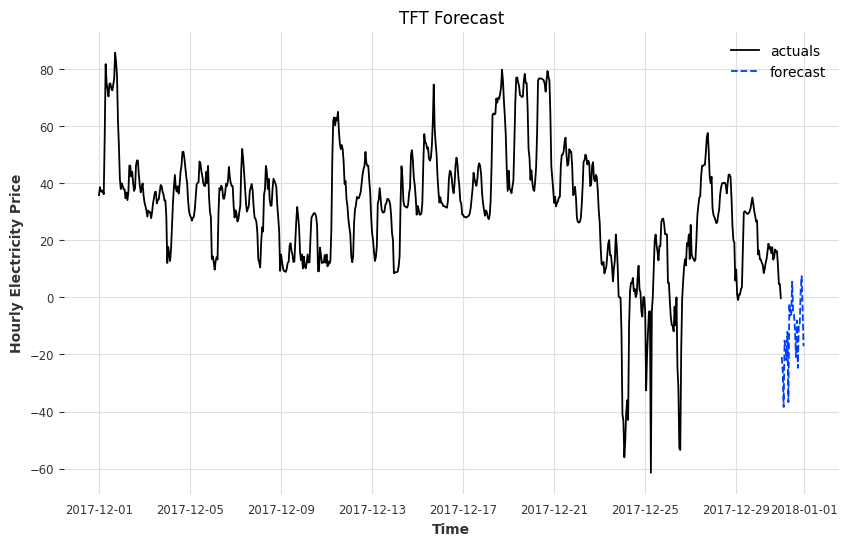

In [43]:
fig, ax = plt.subplots(figsize = (10,6))

ax.plot(df.y['2017-12':], label = "actuals")

ax.plot(forecast, label = "forecast", linestyle = 'dashed')

ax.set_xlabel("Time")
ax.set_ylabel("Hourly Electricity Price")
ax.set_title("TFT Forecast")
ax.legend()
plt.show()

Interpretability

/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 51.71it/s]


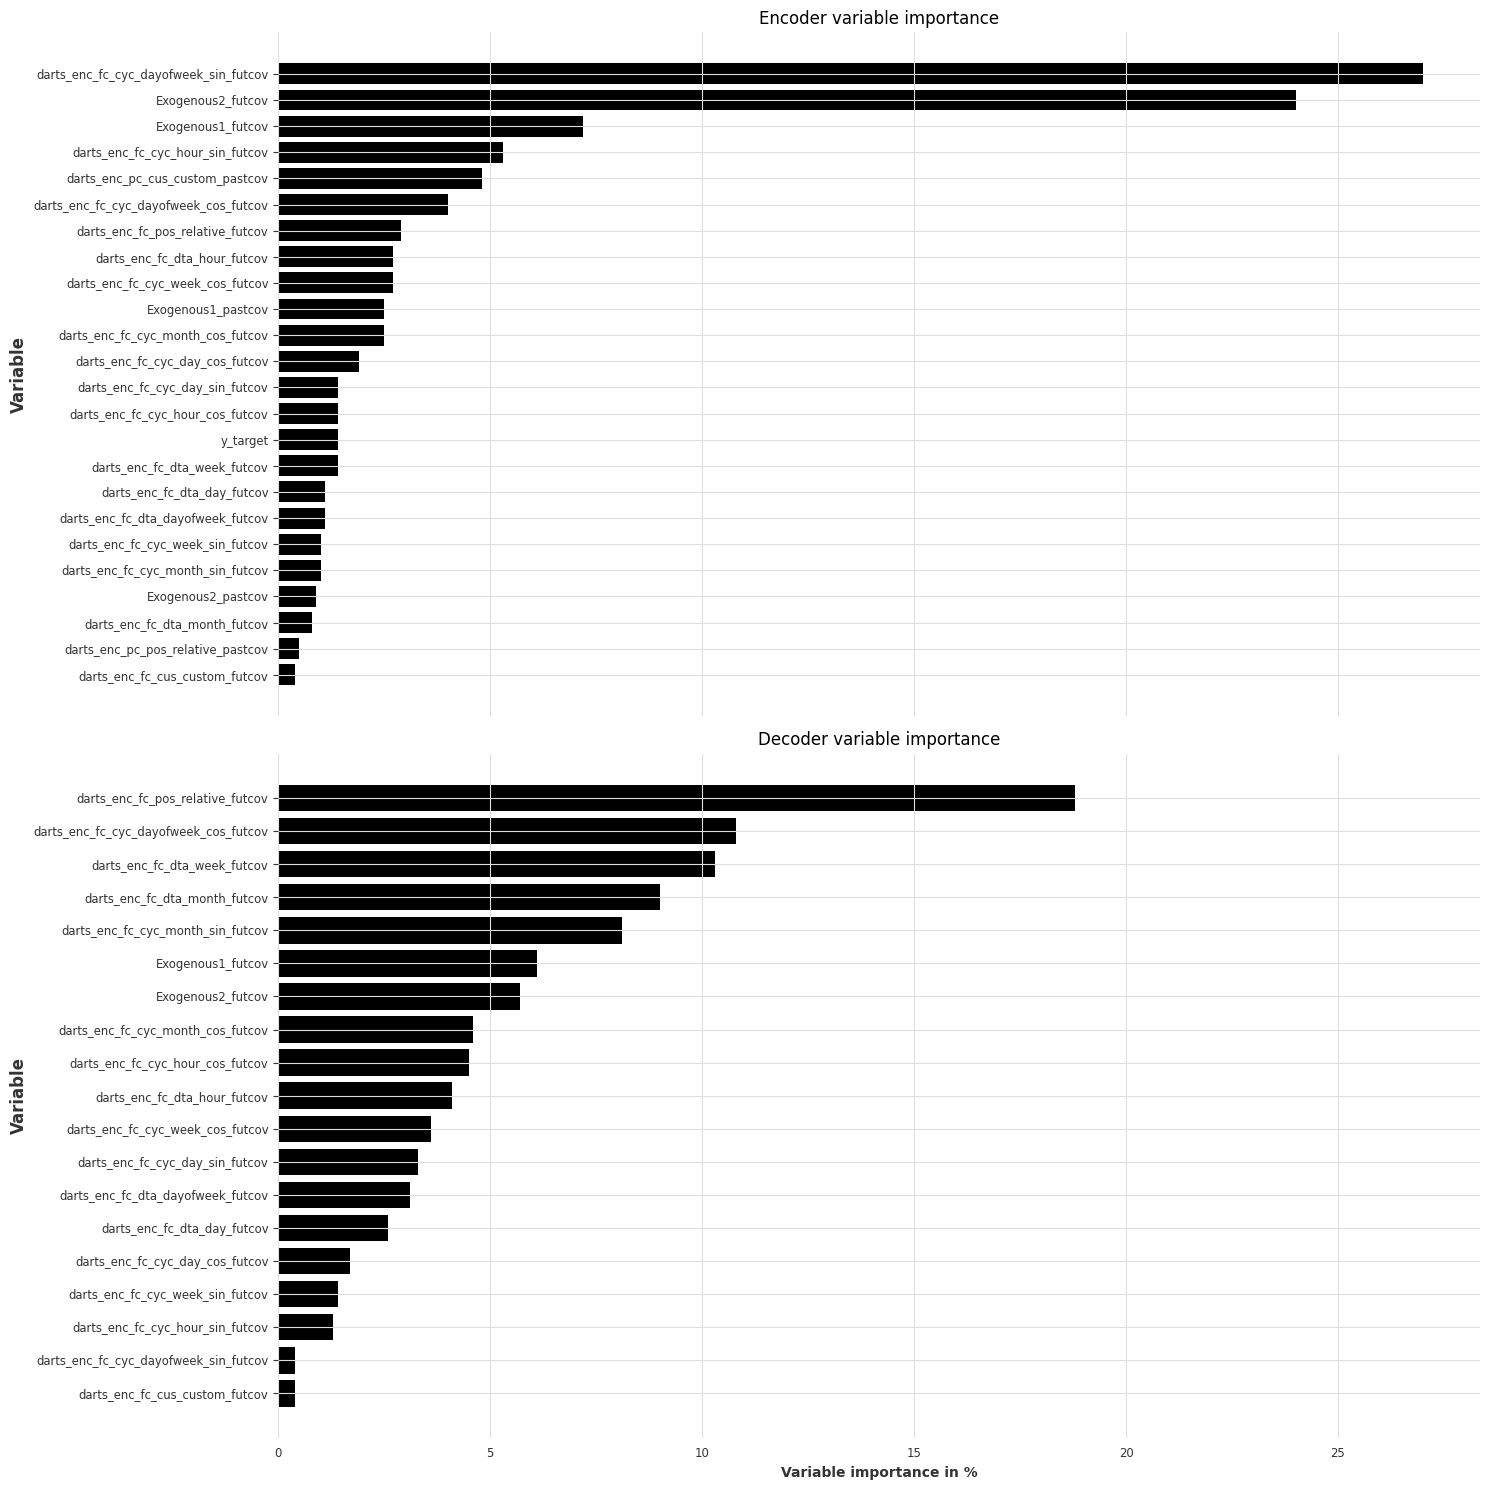

In [44]:
from darts.explainability import TFTExplainer

explainer = TFTExplainer(tuned_model)
explainability_result = explainer.explain()
explainer.plot_variable_selection(explainability_result, fig_size = (15,15))

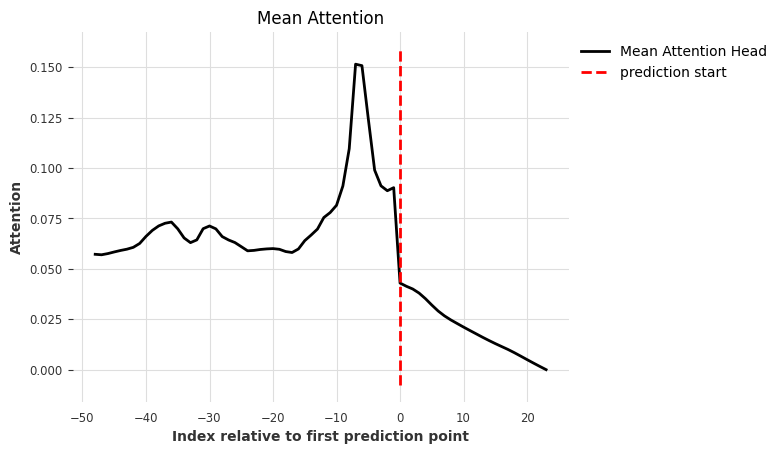

<Axes: title={'center': 'Mean Attention'}, xlabel='Index relative to first prediction point', ylabel='Attention'>

In [45]:
explainer.plot_attention(explainability_result, plot_type = "time")